# Assignment 2

In this Assignment, you will explore the **FIFA 19** dataset, which contains detailed attributes for every player registered in the latest edition of FIFA 19 database.    
It was scrapped from this [website](https://sofifa.com/), and you can find the source code [here](https://github.com/amanthedorkknight/fifa18-all-player-statistics/tree/master/2019).

Your goal is to find out how the `Overall` score by player is calculated

There are 2 main parts:

* Data Import & Cleaning, the output of this part is provided in the csv file `Assignment_2_data_cleaned`, **so you do not need to have everything right in this part to do the second one**
* Modeling with the cleaned data

In the notebook, there will be cells in the form `assert condition` like the next one. They are used to check if an answer is correct.  
Execute the next one and you will get no errors

In [0]:
assert 3 < 5

Execute the next one and you will get an error

In [2]:
assert 3 > 5

AssertionError: ignored

# Data Import

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

os.chdir("/content/drive/My Drive/ECE ML/Week 2/PW_2")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Assignment_2_correction.ipynb	 Bike_Rental_Starter.ipynb
 Assignment_2_data_cleaned.csv	'Bike Rental UCI dataset.csv'
 Assignment_2_data.csv		 Gradient_Descent_animation.ipynb
 Assignment_2.ipynb		 gradient_descent.gif
 Bike_Rental.ipynb


1.1. Load the csv file `data.csv` into a dataframe called `df` and print its shape. (Set the right parameters when reading the csv file)       

In [24]:
df = pd.read_csv('Assignment_2_data.csv',index_col=0)
df.shape

(18207, 88)

In [0]:
# check if your answer is correct
assert df.shape == (18207, 88)

1.2. print the head of `df`

In [26]:
df.head(2)

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M


1.3. Print how many columns that are in df columns types

In [27]:
df.dtypes.value_counts()

object     45
float64    38
int64       5
dtype: int64

1.4. `to_drop` is a list containing columns that are not useful for modeling, remove them and print the new shape of `df`

In [28]:
to_drop =['ID', 'Name', 'Photo','Nationality', 'Flag','Club','Club Logo', 'Real Face', 'Joined', 'Loaned From', 'Contract Valid Until']
df.drop(to_drop, axis = 1, inplace = True)
df.shape

(18207, 77)

In [0]:
# check if your answer is correct
assert df.shape == (18207, 77)

# Data Cleaning

## Handling missing values

2.1. Build a dataframe called `missing` which has the following format:

* `pct` is the percentage of missing values, **takes values between `0` and `100`**
* the index is the column names

|     | pct |
|-----|-----|
|......|.....|
|Strength |0.263635|
|.....|.....|



In [0]:
missing = pd.DataFrame(df.isnull().sum() / len(df) * 100, columns=['pct'])

2.2. Remove from `missing`, rows with `pct`= 0   
sort `missing` in ascending order of `pct` and print its head

In [31]:
missing = missing[missing['pct'] != 0]
missing.sort_values('pct', inplace = True)
missing.head()

,pct
Preferred Foot,0.263635
Strength,0.263635
Stamina,0.263635
Jumping,0.263635
ShotPower,0.263635


2.3. Now, let's fill missing values where the % of missing is lower than 1 (1%).   
First identify these columns in a list named `cols_to_fill`

In [32]:
threshold_missing_to_fill = 1
cols_to_fill = list(missing[missing['pct'] < threshold_missing_to_fill].index)
print(len(cols_to_fill), type(cols_to_fill))

44 <class 'list'>


In [0]:
# check if your answer is correct
assert len(cols_to_fill) == 44; assert isinstance(cols_to_fill, list)

2.4. define a function (`fill_nas_by_type`) to fill null values by column type:

* if a column type is `Object`, fill it with the **most frequent value**
* otherwise, fill it with the **median value**

In [0]:
def fill_nas_by_type(df, col_name):
    """Fill null values in df according to col_name type
    
    Parameters
    ----------
    df : dataframe, (default=None)
        input dataframe
    col_name : str, (default=None)
        column with null values to fill
        
    Returns
    -------
    df with filled values in col_name
    """
    if df[col_name].isnull().sum() == 0:
        print('!! Warning : %s does not have null values' % col_name)
        return df
    if df[col_name].dtype == 'O':
        fill_value = df[col_name].value_counts().index[0]
        df[col_name].fillna(fill_value, inplace = True)
    else:
        fill_value = df[col_name].median()
        df[col_name].fillna(fill_value, inplace = True)
    return df

Loop through `cols_to_fill` and apply the defined function `fill_nas_by_type` to fill null values

In [0]:
for f in cols_to_fill:
    df = fill_nas_by_type(df.copy(), col_name = f)

In [0]:
# check if your answer is correct
assert df[cols_to_fill].isnull().sum().sum() == 0

For the remaining missing values, let's just remove them.    
Print the shape of `df` before and after removing any rows with missing observations

In [37]:
print(df.shape)
df.dropna(axis = 0, inplace = True)
print(df.shape)

(18207, 77)
(14743, 77)


In [0]:
# check if your answer is correct
assert df.shape == (14743, 77); assert df.isnull().sum().sum() == 0

## Correct some columns format

### Monetary columns

In [39]:
money_cols = ['Value','Wage', 'Release Clause']
df[money_cols].head()

,Value,Wage,Release Clause
0,€110.5M,€565K,€226.5M
1,€77M,€405K,€127.1M
2,€118.5M,€290K,€228.1M
4,€102M,€355K,€196.4M
5,€93M,€340K,€172.1M


3.1. Build a function which extracts the monetary value from a string. It should return a number with no decimals.   
Your function should pass the three tests in the cell after

In [0]:
def get_value(value_text):
    """Extract the monetary value from a string
    
    Parameters
    ----------
    value_text: str, (default=None)
        a string containing a number ending with M, K or nothing
        
    Returns
    -------
    a float with no decimals
    
    Examples
    --------
    >>> get_value('€7.1K')
    7100.0
    """
    multiplier = value_text[-1]
    if multiplier == 'M':
        number = float(value_text[1:-1])
        return number * 1000000
    elif multiplier == 'K':
        number = float(value_text[1:-1])
        return number * 1000
    else:
        return float(value_text[1:])    

In [0]:
# check if your answer is correct
assert get_value('€110.5M') == 110500000; assert get_value('€7.1K') == 7100; assert get_value('€200') == 200

3.2. Loop through `money_cols` and apply the defined function `get_value` to convert them to numeric

In [42]:
for f in money_cols:
    df[f] =df[f].apply(get_value)
    print(f, df[f].dtype, df[f].isnull().sum())

Value float64 0
Wage float64 0
Release Clause float64 0


In [44]:
# check if your answer is correct
assert df[money_cols].isnull().sum().sum() == 0
print(df[money_cols])

             Value      Wage  Release Clause
0      110500000.0  565000.0     226500000.0
1       77000000.0  405000.0     127100000.0
2      118500000.0  290000.0     228100000.0
4      102000000.0  355000.0     196400000.0
5       93000000.0  340000.0     172100000.0
...            ...       ...             ...
18202      60000.0    1000.0        143000.0
18203      60000.0    1000.0        113000.0
18204      60000.0    1000.0        165000.0
18205      60000.0    1000.0        143000.0
18206      60000.0    1000.0        165000.0

[14743 rows x 3 columns]


### Height and Weight columns

4.1. Start by printing the unique values for `Height`

In [45]:
# print unique values for Height
df['Height'].unique()

array(["5'7", "6'2", "5'9", "5'11", "5'8", "6'0", "5'6", "5'10", "6'1",
       "5'4", "6'3", "6'4", "5'5", "6'6", "6'5", "5'3", "5'2", "6'7",
       "5'1", "6'8"], dtype=object)

4.2. Write a function (`get_height`) which converts the Height from a string in feet to  a number in `cm` with no decimals.    
1 feet = 30.48 cm. For example `get_height("5'10")` = `155`

In [0]:
def get_height(x):
    return  round(float(x.replace("'", ".")) * 30.48, 0) 

In [0]:
# check if your answer is correct
assert get_height("5'10") == 155; assert get_height("6'8") == 207

Apply the previous defined function on `Height`

In [0]:
df['Height'] = df['Height'].apply(get_height)

In [0]:
# check if your answer is correct
assert df['Height'].dtype == 'float64'; assert df['Height'].isnull().sum() == 0

4.3. The same thing with `Weight`, print the unique values

In [50]:
# print unique values for Weight
df['Weight'].unique()

array(['159lbs', '183lbs', '150lbs', '154lbs', '163lbs', '146lbs',
       '190lbs', '181lbs', '176lbs', '168lbs', '172lbs', '148lbs',
       '165lbs', '196lbs', '161lbs', '170lbs', '187lbs', '157lbs',
       '185lbs', '130lbs', '174lbs', '203lbs', '207lbs', '134lbs',
       '141lbs', '152lbs', '179lbs', '132lbs', '198lbs', '201lbs',
       '209lbs', '214lbs', '143lbs', '192lbs', '137lbs', '194lbs',
       '139lbs', '220lbs', '205lbs', '216lbs', '126lbs', '123lbs',
       '128lbs', '223lbs', '212lbs', '121lbs', '115lbs', '218lbs',
       '117lbs', '243lbs', '110lbs', '119lbs', '234lbs'], dtype=object)

4.4. Write a function (`get_weight`) which converts the **Weight** from a string in `lbs` to a number in `kg` with no decimals.    
1 lbs = 0.453592 kg. For example `get_weight("115lbs")` = `52`

In [0]:
def get_weight(x):
    return  round(float(x.split('lbs')[0]) * 0.453592, 0)

In [0]:
# check if your answer is correct
assert get_weight("115lbs") == 52; assert get_weight("234lbs") == 106

Apply the previous defined function on `Weight`

In [0]:
df['Weight'] = df['Weight'].apply(get_weight)

In [56]:
# check if your answer is correct
assert df['Weight'].dtype == 'float64'; assert df['Weight'].isnull().sum() == 0

df["Height"].head()

0    174.0
1    189.0
2    180.0
4    156.0
5    177.0
Name: Height, dtype: float64

## Convert text columns to numeric

5.1. Identify non-numeric text columns in a list called `text_cols`

In [57]:
text_cols = [f for f in df.columns if df[f].dtype == 'O']
print(len(text_cols))

30


5.2. Build a list named `cols_to_remove` containing columns from `text_cols`, if a column has a number of unique values greater than **10** (`> 10`)

In [58]:
cols_to_remove = []
threshold_too_many_unics = 10
for f in text_cols:
    if df[f].nunique() > threshold_too_many_unics:
        cols_to_remove.append(f)
print(len(cols_to_remove))

27


remove `cols_to_remove` columns from `df` and print its shape

In [59]:
df.drop(cols_to_remove, axis = 1, inplace = True)
df.shape

(14743, 50)

In [0]:
# check if your answer is correct
assert df.shape == (14743, 50)

5.3. Identify the remaining text columns in `text_cols` as `remaining_text_cols`, make sur it passes the test after

In [61]:
remaining_text_cols = [f for f in df.columns if df[f].dtype == 'O']
print(len(remaining_text_cols))

3


In [0]:
# check if your answer is correct
assert remaining_text_cols == ['Preferred Foot', 'Work Rate', 'Body Type']

5.4. Loop through `remaining_text_cols` and convert them to numerical values

In [0]:
for f in remaining_text_cols:
    df[f]= df[f].astype("category").cat.codes

In [64]:
df.shape

(14743, 50)

In [0]:
# df.to_csv('Assignment_2_data_cleaned.csv', index = False)

# Model building

As stated before, you can do this part without completing the previous one

6.1. Load the cleaned dataset `Assignment_2_data_cleaned.csv` into `df_clean` and print its shape.    

In [65]:
df_clean = pd.read_csv('Assignment_2_data_cleaned.csv')
df_clean.shape

(14743, 50)

6.2. Load the target variable `Overall` into a dataframe and name it `y`. Then, load the features into a second dataframe and name it `X`. Plot a histogram of `y`, choose the number of bins as 100.

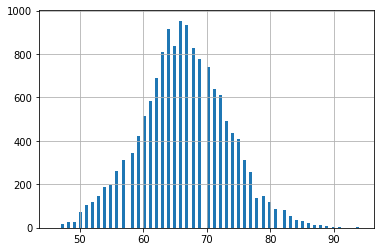

In [70]:
y = df_clean.Overall
X = df_clean.drop('Overall', axis=1, inplace=False)
y.hist(bins=100)

7. Split the data set into a training set and a test set. Choose `test_size` = 0.3 and `random_state` = 123  
Print train and test size      
**Attention**: You are asked to use  [`sklearn.model_selection`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [74]:
from sklearn.model_selection import train_test_split
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
print("train set shape: ", X_train.shape, y_train.shape)
print("test set shape: ", X_test.shape, y_test.shape)

(14743, 49)
(14743,)
train set shape:  (10320, 49) (10320,)
test set shape:  (4423, 49) (4423,)


8. Fit a linear model to the training set, and then report the training and testing errors obtained (the R2 statistic).   
Calculate and print the following metrics: mse, rmse, mae for the test_set

In [75]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)
train_score = reg.score(X_train, y_train)
test_score=reg.score(X_test, y_test)
print  ('train score =', train_score)
print  ('test score = {}'.format(test_score))

train score = 0.9370091958866428
test score = 0.9357188804626775


In [76]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)  
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test,y_pred)
print ('mse = {}, rmse = {} \nmae = {} r2 = {}'.format(mse,math.sqrt(mse), mae, r2))

mse = 3.0074136038004893, rmse = 1.7341896101062564 
mae = 1.3561926131609652 r2 = 0.9357188804626775


### Check residuals

9.1. Plot a histogram of the residuals (difference between `y_test` and `y_pred`

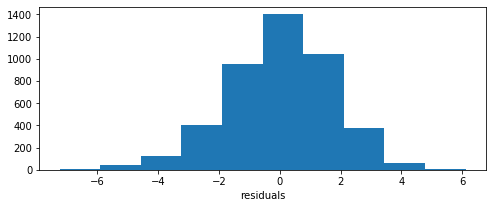

In [77]:
plt.figure(figsize= (8, 3))
plt.hist(y_test - y_pred)
plt.xlabel('residuals')
plt.ylabel('')
plt.show()

9.2. Plot a scatter plot where `y_test` is in the **x** axis and  `y_pred` is in the **y** axis

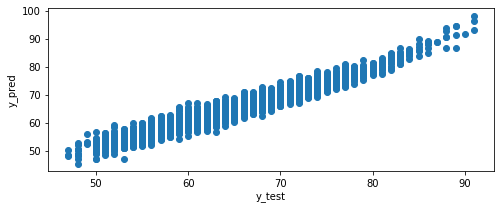

In [78]:
plt.figure(figsize= (8, 3))
plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

10. Try to improve the performance of your model, by adding new features

In [0]:
X['wage_ratio'] = X['Wage'] / X['Value']

In [0]:
value_by_age = X.groupby('Age')['Value'].median().to_dict()
X['value_by_age_median'] = X['Age'].map(value_by_age)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
reg=LinearRegression()
reg.fit(X_train, y_train)
train_score = reg.score(X_train, y_train)
test_score=reg.score(X_test, y_test)
print  ('train score =', train_score)
print  ('test score = {}'.format(test_score))

train score = 0.9563947619903304
test score = 0.9551376523521644


In [130]:
#print(reg.coef_)
index_to_predict = 0
print("Value to predict is ",y[index_to_predict])

print(reg.predict(np.array(X.iloc[index_to_predict]).reshape(1,-1))[0])

Value to predict is  94
101.23071348014632
